#prueba 2

Se pide implementar un sistema que permita el procesamiento digital de imágenes para identificar y segmentar áreas de piel y cabello en el flujo de video

Primero usaremos el codigo predeterminado por collab para capturar la camara como una foto

Aqui se capturar una foto usando la cámara web en Google Colab. Importa módulos para mostrar y ejecutar JavaScript, y decodificar datos base64. Define una función take_photo que crea un botón "Capture" y un elemento de video. Accede a la cámara web, muestra el video y espera a que se haga clic en "Capture". Captura un fotograma, lo dibuja en un canvas, detiene el video y elimina los elementos HTML. Luego, devuelve la imagen en base64, la decodifica y la guarda como un archivo local.

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Aqui se complementa la función take_photo para capturar y mostrar una imagen utilizando la cámara web en Google Colab.

Primero importa la clase Image de IPython.display para poder mostrar la imagen capturada más adelante. Luego, intenta capturar una foto usando la función take_photo(), y guarda el nombre del archivo resultante en la variable filename. A continuación, imprime un mensaje de confirmación indicando que la imagen se guardó correctamente con el nombre del archivo.

Posteriormente, utiliza la función display() para mostrar la imagen capturada en la notebook. Finalmente, maneja posibles excepciones que puedan ocurrir si el usuario no tiene una cámara web o no otorga permiso para acceder a ella, imprimiendo el mensaje de error correspondiente.

<IPython.core.display.Javascript object>

Saved to photo.jpg


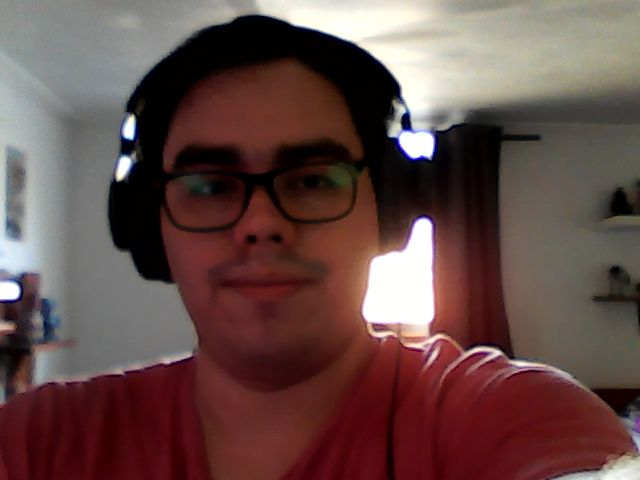

In [4]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Aqui se va a segmentar la piel y detectar el cabello en imágenes capturadas desde una cámara web. Utiliza el espacio de color HSV para segmentar la piel mediante umbrales ajustables, y el detector de bordes de Canny para detectar el cabello. Los parámetros de segmentación se pueden ajustar interactivamente con controles deslizantes. La imagen original, la segmentación de piel y la detección de cabello se muestran en tres paneles. Además, el código captura una foto en vivo, procesándola para mostrar los resultados de segmentación y detección en tiempo real.

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def segment_skin_hsv_interactive(frame, h_low, h_high, s_low, s_high, v_low, v_high):
    """
    Segmenta áreas de piel en el espacio de color HSV usando umbrales ajustables.
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([h_low, s_low, v_low], dtype=np.uint8)
    upper_skin = np.array([h_high, s_high, v_high], dtype=np.uint8)
    mask_skin = cv2.inRange(hsv, lower_skin, upper_skin)

    # Aplicar postprocesamiento: dilatar la máscara para reducir pequeños agujeros
    kernel = np.ones((5,5), np.uint8)
    mask_skin = cv2.dilate(mask_skin, kernel, iterations=1)

    return mask_skin

def detect_hair(frame):
    """
    Detecta el cabello utilizando análisis de bordes con Canny y umbrales.
    """
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Aplicar el detector de bordes Canny
    edges = cv2.Canny(gray, 100, 200)

    # Usar dilatación para mejorar los bordes detectados
    dilated_edges = cv2.dilate(edges, None, iterations=1)

    # Convertir los bordes dilatados a imagen BGR para sobreponer sobre la imagen original
    hair_mask = cv2.cvtColor(dilated_edges, cv2.COLOR_GRAY2BGR)

    return hair_mask

def process_frame_with_interactivity(frame):
    """
    Procesa un fotograma y permite ajustar los umbrales para segmentar piel y detectar cabello.
    """
    def update(h_low, h_high, s_low, s_high, v_low, v_high):
        # Segmentación de piel interactiva
        mask_skin = segment_skin_hsv_interactive(frame, h_low, h_high, s_low, s_high, v_low, v_high)
        skin_overlay = cv2.bitwise_and(frame, frame, mask=mask_skin)

        # Detección de cabello
        mask_hair = detect_hair(frame)
        hair_overlay = cv2.addWeighted(frame, 0.7, mask_hair, 0.3, 0)

        # Mostrar resultados
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Segmentación de Piel")
        plt.imshow(cv2.cvtColor(skin_overlay, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Detección de Cabello")
        plt.imshow(cv2.cvtColor(hair_overlay, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

    interact(
        update,
        h_low=IntSlider(min=0, max=179, value=0, description="H Low"),
        h_high=IntSlider(min=0, max=179, value=20, description="H High"),
        s_low=IntSlider(min=0, max=255, value=50, description="S Low"),
        s_high=IntSlider(min=0, max=255, value=255, description="S High"),
        v_low=IntSlider(min=0, max=255, value=50, description="V Low"),
        v_high=IntSlider(min=0, max=255, value=255, description="V High")
    )

def capture_and_process_with_interactivity():
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capture';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});

                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();

                google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                await new Promise((resolve) => capture.onclick = resolve);

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    filename = take_photo()
    frame = cv2.imread(filename)
    process_frame_with_interactivity(frame)

capture_and_process_with_interactivity()


<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='H Low', max=179), IntSlider(value=20, description='H Hig…

Aqui se capturar una imagen en vivo desde la cámara web y realizar la detección de cabello en ella. La imagen se convierte a escala de grises y se aplican bordes utilizando el algoritmo de Canny. Estos bordes se dilatan para hacerlos más prominentes y mejorar la detección. Luego, la imagen procesada se combina con la original para resaltar las áreas detectadas como cabello. Todo el proceso es interactivo, lo que permite capturar y analizar la imagen en tiempo real, mostrando los resultados de la detección de cabello en comparación con la imagen original.

<IPython.core.display.Javascript object>

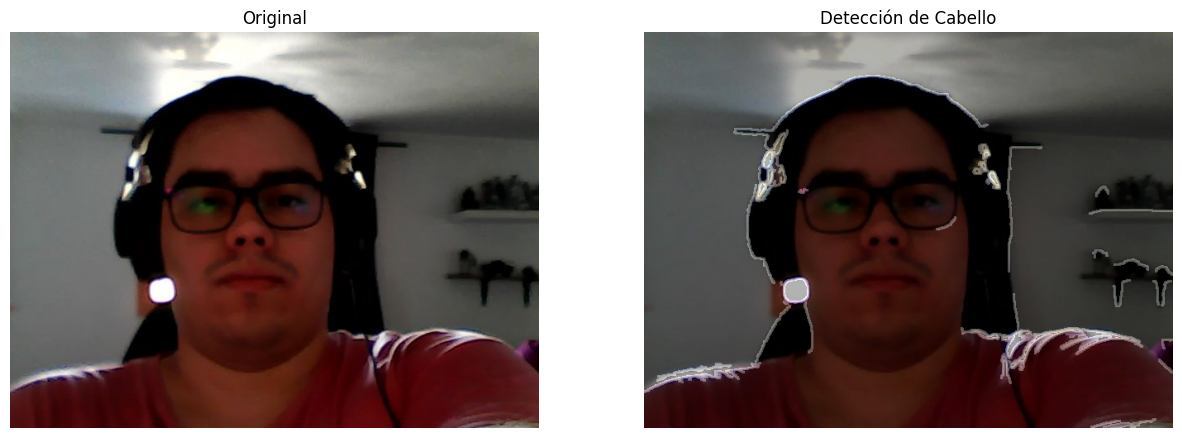

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def detect_hair(frame):
    """
    Detecta el cabello utilizando análisis de bordes con Canny y umbrales.
    """
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Aplicar el detector de bordes Canny
    edges = cv2.Canny(gray, 100, 200)

    # Usar dilatación para mejorar los bordes detectados
    dilated_edges = cv2.dilate(edges, None, iterations=1)

    # Convertir los bordes dilatados a imagen BGR para sobreponer sobre la imagen original
    hair_mask = cv2.cvtColor(dilated_edges, cv2.COLOR_GRAY2BGR)

    return hair_mask

def process_frame_with_interactivity(frame):
    """
    Procesa un fotograma y permite ajustar los umbrales para detectar el cabello.
    """
    def update():
        # Detección de cabello
        mask_hair = detect_hair(frame)
        hair_overlay = cv2.addWeighted(frame, 0.7, mask_hair, 0.3, 0)

        # Mostrar resultados
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Detección de Cabello")
        plt.imshow(cv2.cvtColor(hair_overlay, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

    update()

def capture_and_process_with_interactivity():
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capture';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});

                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();

                google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                await new Promise((resolve) => capture.onclick = resolve);

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    filename = take_photo()
    frame = cv2.imread(filename)
    process_frame_with_interactivity(frame)

capture_and_process_with_interactivity()


sE segmentaN áreas de piel en una imagen utilizando el espacio de color HSV, donde se establecen umbrales ajustables para los valores de hue, saturation y value. Convierte la imagen a HSV y crea una máscara que resalta las áreas de piel según los umbrales definidos. Luego, superpone la máscara a la imagen original, mostrando solo las áreas de piel seleccionadas.

La parte interactiva permite ajustar esos umbrales en tiempo real mediante controles deslizantes. Los valores de hue, saturation y value se pueden modificar para refinar la segmentación de la piel. Además, la imagen de la cámara se captura a través de la interfaz de Google Colab, y luego se procesa usando la segmentación de piel.

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def segment_skin_hsv(frame, h_low, h_high, s_low, s_high, v_low, v_high):
    """
    Segmenta áreas de piel en el espacio de color HSV usando umbrales ajustables.
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([h_low, s_low, v_low], dtype=np.uint8)
    upper_skin = np.array([h_high, s_high, v_high], dtype=np.uint8)
    mask_skin = cv2.inRange(hsv, lower_skin, upper_skin)
    return mask_skin

def process_frame_with_interactivity(frame):
    """
    Procesa un fotograma y permite ajustar los umbrales para segmentar piel.
    """
    def update(h_low, h_high, s_low, s_high, v_low, v_high):
        # Segmentación de piel
        mask_skin = segment_skin_hsv(frame, h_low, h_high, s_low, s_high, v_low, v_high)
        skin_overlay = cv2.bitwise_and(frame, frame, mask=mask_skin)

        # Mostrar resultados
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Segmentación de Piel")
        plt.imshow(cv2.cvtColor(skin_overlay, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

    interact(
        update,
        h_low=IntSlider(min=0, max=179, value=0, description="H Low"),
        h_high=IntSlider(min=0, max=179, value=20, description="H High"),
        s_low=IntSlider(min=0, max=255, value=50, description="S Low"),
        s_high=IntSlider(min=0, max=255, value=255, description="S High"),
        v_low=IntSlider(min=0, max=255, value=50, description="V Low"),
        v_high=IntSlider(min=0, max=255, value=255, description="V High")
    )

def capture_and_process_with_interactivity():
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capture';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});

                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();

                google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                await new Promise((resolve) => capture.onclick = resolve);

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    filename = take_photo()
    frame = cv2.imread(filename)
    process_frame_with_interactivity(frame)

capture_and_process_with_interactivity()


<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='H Low', max=179), IntSlider(value=20, description='H Hig…

##AHORA LO APLICAMOS CON OPERACIONES MORFOLOGICAS

Captura una foto desde la cámara  y procesa la imagen para resaltar las áreas de cabello negro. Primero convierte la imagen a escala de grises y aplica un umbral para identificar las zonas oscuras. Luego utiliza operaciones morfológicas (dilatación o erosión) para mejorar la detección. Finalmente,muestra tanto la imagen original como la imagen con el cabello resaltado

<IPython.core.display.Javascript object>

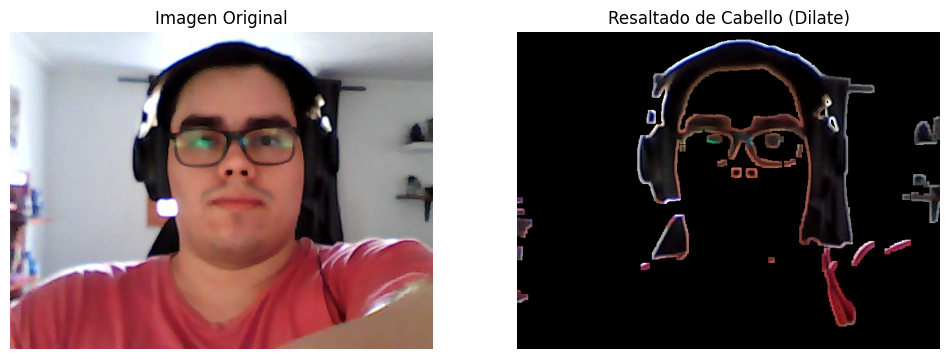

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Función para capturar la foto
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Función para detectar y resaltar el cabello negro
def detect_and_highlight_hair(frame, threshold_value=50, kernel_size=5, operation='dilate'):
    """
    Detecta las zonas oscuras (cabello negro) y las resalta.
    """
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Aplicar un umbral bajo para resaltar las áreas más oscuras (cabello negro)
    _, hair_mask = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)  # Invertimos el umbral

    # Definir el kernel morfológico para la operación
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Aplicar la operación morfológica (dilatación o erosión)
    if operation == 'dilate':
        hair_mask = cv2.dilate(hair_mask, kernel, iterations=2)
    elif operation == 'erode':
        hair_mask = cv2.erode(hair_mask, kernel, iterations=2)

    # Resaltar el cabello negro en la imagen
    hair_highlight = cv2.bitwise_and(frame, frame, mask=hair_mask)

    return hair_highlight

# Función para mostrar la imagen con la detección de cabello resaltada
def process_frame_with_hair_highlight(frame, operation='dilate'):
    # Detectar y resaltar el cabello negro
    hair_highlight = detect_and_highlight_hair(frame, operation=operation)

    # Mostrar la imagen original y la detección de cabello resaltado
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Resaltado de Cabello ({operation.capitalize()})")
    plt.imshow(cv2.cvtColor(hair_highlight, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Capturar y procesar la foto
filename = take_photo()
frame = cv2.imread(filename)

# Procesar la imagen para resaltar el cabello negro
process_frame_with_hair_highlight(frame, operation='dilate')  # Cambiar a 'erode' si prefier


Se captura una imagen desde la cámara  y segmenta la piel en la imagen utilizando el espacio de color HSV. Primero, se convierte la imagen a HSV y se aplican umbrales ajustables para identificar las zonas que corresponden a la piel. Luego, se aplica una operación morfológica, como dilatación o erosión, para mejorar la segmentación de la piel. La piel segmentada se resalta en verde para hacerla más visible.

<IPython.core.display.Javascript object>

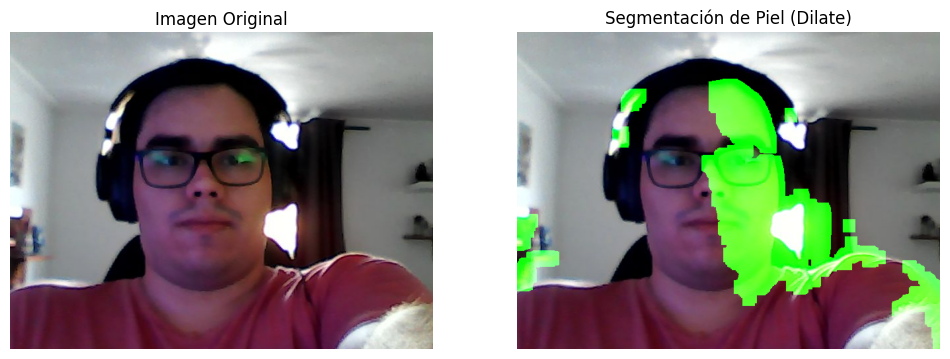

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Función para capturar la foto
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Función para segmentar piel usando el espacio de color HSV
def segment_skin_hsv(frame, h_low=0, h_high=20, s_low=50, s_high=255, v_low=50, v_high=255):
    """
    Segmenta la piel en el espacio de color HSV con umbrales ajustables.
    """
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Definir los rangos de color para la piel
    lower_skin = np.array([h_low, s_low, v_low], dtype=np.uint8)
    upper_skin = np.array([h_high, s_high, v_high], dtype=np.uint8)

    # Crear una máscara para la piel
    mask_skin = cv2.inRange(hsv, lower_skin, upper_skin)

    return mask_skin

# Función para aplicar operaciones morfológicas (dilatación o erosión) a la máscara
def apply_morphological_operations(mask, operation='dilate', kernel_size=7):
    """
    Aplica operaciones morfológicas (dilatación o erosión) para mejorar la máscara.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    if operation == 'dilate':
        return cv2.dilate(mask, kernel, iterations=3)  # Aumenta las áreas de piel
    elif operation == 'erode':
        return cv2.erode(mask, kernel, iterations=2)  # Reduce las áreas de piel
    else:
        return mask

# Función para mostrar la segmentación de piel con operaciones morfológicas
def process_frame_with_skin_segmentation(frame, operation='dilate'):
    # Segmentación de la piel
    skin_mask = segment_skin_hsv(frame)

    # Aplicar operación morfológica
    skin_mask_morphed = apply_morphological_operations(skin_mask, operation=operation)

    # Resaltar las áreas de piel con un color (verde) para que sea más visible
    skin_highlight = cv2.bitwise_and(frame, frame, mask=skin_mask_morphed)

    # Convertir la imagen de piel resaltada a un tono verde
    green_overlay = frame.copy()
    green_overlay[:, :, 1] = cv2.add(green_overlay[:, :, 1], skin_mask_morphed)

    # Mostrar la imagen original y la segmentación de la piel
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Segmentación de Piel ({operation.capitalize()})")
    plt.imshow(cv2.cvtColor(green_overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Capturar y procesar la foto
filename = take_photo()
frame = cv2.imread(filename)

# Procesar la imagen para segmentar la piel con dilatación
process_frame_with_skin_segmentation(frame, operation='dilate')  # Cambiar a 'erode' si prefieres erosión


In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def segment_skin_hsv_interactive(frame, h_low, h_high, s_low, s_high, v_low, v_high):
    """
    Segmenta áreas de piel en el espacio de color HSV usando umbrales ajustables.
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([h_low, s_low, v_low], dtype=np.uint8)
    upper_skin = np.array([h_high, s_high, v_high], dtype=np.uint8)
    mask_skin = cv2.inRange(hsv, lower_skin, upper_skin)

    # Operaciones morfológicas más suaves
    kernel = np.ones((5, 5), np.uint8)  # Kernel más pequeño
    mask_skin = cv2.dilate(mask_skin, kernel, iterations=1)  # Dilatación ligera
    mask_skin = cv2.erode(mask_skin, kernel, iterations=1)  # Erosión ligera

    return mask_skin

def process_frame_with_interactivity(frame):
    """
    Procesa un fotograma y permite ajustar los umbrales para segmentar piel.
    """
    def update(h_low, h_high, s_low, s_high, v_low, v_high):
        # Segmentación de piel interactiva
        mask_skin = segment_skin_hsv_interactive(frame, h_low, h_high, s_low, s_high, v_low, v_high)
        mask_skin = cv2.cvtColor(mask_skin, cv2.COLOR_GRAY2BGR)  # Convertir a BGR para visualización

        # Mostrar resultados
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Segmentación de Piel")
        plt.imshow(cv2.cvtColor(mask_skin, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

    interact(
        update,
        h_low=IntSlider(min=0, max=179, value=0, description="H Low"),
        h_high=IntSlider(min=0, max=179, value=20, description="H High"),
        s_low=IntSlider(min=0, max=255, value=50, description="S Low"),
        s_high=IntSlider(min=0, max=255, value=255, description="S High"),
        v_low=IntSlider(min=0, max=255, value=50, description="V Low"),
        v_high=IntSlider(min=0, max=255, value=255, description="V High")
    )

def capture_and_process_with_interactivity():
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capture';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});

                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();

                google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                await new Promise((resolve) => capture.onclick = resolve);

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    filename = take_photo()
    frame = cv2.imread(filename)
    process_frame_with_interactivity(frame)

capture_and_process_with_interactivity()


<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='H Low', max=179), IntSlider(value=20, description='H Hig…

##APLICARLOS EN TIEMPO REAL


Aqui se capturar video en vivo desde la cámara web en Google Colab, procesar los fotogramas con OpenCV y superponer imágenes (como cajas delimitadoras) en el flujo de video. Utiliza funciones en JavaScript y Python para capturar imágenes, convertirlas en formato base64 y enviarlas entre ambos entornos. Además, se carga un clasificador Haar Cascade para la detección de rostros. Todo esto se integra para realizar tareas de visión por computadora en tiempo real.

In [40]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: {facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes2(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'L')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes3(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGB')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

  # initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

segmentacion de piel

Captura video desde la cámara web, procesa cada fotograma para detectar bordes y segmentar las áreas de piel y cabello, fusionando estas áreas con el fondo modificado. Utiliza JavaScript para la captura del video y lo convierte a una imagen de OpenCV. Luego, aplica el algoritmo de Canny para detectar bordes, con un procesamiento morfológico para mejorar los resultados. Los fotogramas se convierten al espacio de color HSV, y se crean máscaras para segmentar la piel y el cabello según rangos de colores específicos. Estas máscaras se aplican al fotograma original y las imágenes de piel, cabello y fondo se combinan. Finalmente, la imagen resultante se convierte a formato base64 para su visualización en tiempo real.

In [53]:
import numpy as np
import cv2

# Iniciar transmisión
video_stream()

label_html = 'Capturing...'
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_img, 10, 30)
    edges = cv2.dilate(edges, None, iterations=1)
    edges = cv2.erode(edges, None, iterations=1)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_skin = np.array([1, 10, 10])
    upper_skin = np.array([150, 155, 150])
    lower_hair_hsv = np.array([1, 1, 1])
    upper_hair_hsv = np.array([106, 96, 94])

    skin_mask = cv2.inRange(img_hsv, lower_skin, upper_skin)
    skin_edges = cv2.bitwise_and(edges, edges, mask=skin_mask)
    hair_mask_hsv = cv2.inRange(img_hsv, lower_hair_hsv, upper_hair_hsv)
    hair_edges = cv2.bitwise_and(edges, edges, mask=hair_mask_hsv)

    piel = cv2.bitwise_and(img, img, mask=skin_mask + skin_edges)
    cabello = cv2.bitwise_and(img, img, mask=hair_mask_hsv + hair_edges)

    fondo = cv2.bitwise_and(img, img, mask=~(skin_mask + hair_edges))

    final_img = cv2.add(fondo, piel)
    final_img = cv2.add(final_img, cabello)

    bbox_bytes = bbox_to_bytes3(final_img)
    bbox = bbox_bytes

    count += 1


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

Se captura un fotograma de video, se convierte a escala de grises, y se aplica la detección de bordes Canny para resaltar los bordes. Luego, la imagen se convierte a formato HSV para una segmentación más precisa de la piel y el cabello, creando máscaras para cada uno en función de los valores ajustables. Estas máscaras se aplican a la imagen original, destacando las áreas de piel, cabello y fondo. Finalmente, la imagen procesada se muestra en tiempo real usando cv2_imshow, permitiendo ver los cambios mientras se ajustan los parámetros.

In [54]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import ipywidgets as widgets
from ipywidgets import interact

video_stream()

label_html = 'Capturing...'
bbox = ''
count = 0

def nothing(x):
    pass

def update_image(lower_skin_h, upper_skin_h, lower_skin_s, upper_skin_s, lower_skin_v, upper_skin_v,
                 lower_hair_h, upper_hair_h, lower_hair_s, upper_hair_s, lower_hair_v, upper_hair_v,
                 canny_lower, canny_upper):

    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        return

    img = js_to_image(js_reply["img"])
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray_img, canny_lower, canny_upper)
    edges = cv2.dilate(edges, None, iterations=1)
    edges = cv2.erode(edges, None, iterations=1)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_skin = np.array([lower_skin_h, lower_skin_s, lower_skin_v])
    upper_skin = np.array([upper_skin_h, upper_skin_s, upper_skin_v])

    skin_mask = cv2.inRange(img_hsv, lower_skin, upper_skin)

    skin_edges = cv2.bitwise_and(edges, edges, mask=skin_mask)

    piel = cv2.bitwise_and(img, img, mask=skin_mask + skin_edges)

    lower_hair = np.array([lower_hair_h, lower_hair_s, lower_hair_v])
    upper_hair = np.array([upper_hair_h, upper_hair_s, upper_hair_v])

    hair_mask_hsv = cv2.inRange(img_hsv, lower_hair, upper_hair)

    hair_edges = cv2.bitwise_and(edges, edges, mask=hair_mask_hsv)

    cabello = cv2.bitwise_and(img, img, mask=hair_mask_hsv + hair_edges)

    fondo = cv2.bitwise_and(img, img, mask=skin_mask + hair_edges)

    final_img = cv2.add(fondo, piel)
    final_img = cv2.add(final_img, cabello)

    cv2_imshow(final_img)
    plt.axis('off')
    plt.show()

interact(update_image,
         lower_skin_h=widgets.IntSlider(min=0, max=180, step=1, value=1),
         upper_skin_h=widgets.IntSlider(min=0, max=180, step=1, value=150),
         lower_skin_s=widgets.IntSlider(min=0, max=255, step=1, value=10),
         upper_skin_s=widgets.IntSlider(min=0, max=255, step=1, value=155),
         lower_skin_v=widgets.IntSlider(min=0, max=255, step=1, value=10),
         upper_skin_v=widgets.IntSlider(min=0, max=255, step=1, value=150),

         lower_hair_h=widgets.IntSlider(min=0, max=180, step=1, value=1),
         upper_hair_h=widgets.IntSlider(min=0, max=180, step=1, value=106),
         lower_hair_s=widgets.IntSlider(min=0, max=255, step=1, value=1),
         upper_hair_s=widgets.IntSlider(min=0, max=255, step=1, value=96),
         lower_hair_v=widgets.IntSlider(min=0, max=255, step=1, value=1),
         upper_hair_v=widgets.IntSlider(min=0, max=255, step=1, value=94),

         canny_lower=widgets.IntSlider(min=0, max=255, step=1, value=10),
         canny_upper=widgets.IntSlider(min=0, max=255, step=1, value=30)
        )

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=1, description='lower_skin_h', max=180), IntSlider(value=150, descriptio…

<function __main__.update_image(lower_skin_h, upper_skin_h, lower_skin_s, upper_skin_s, lower_skin_v, upper_skin_v, lower_hair_h, upper_hair_h, lower_hair_s, upper_hair_s, lower_hair_v, upper_hair_v, canny_lower, canny_upper)>